# Rare subword corpus evaluation

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
from hydra import compose, initialize
from hydra.core.config_store import ConfigStore
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append('../')

from src.utils.data import DatasetPreprocessor, POSLookup
from src.utils.data import POS_TAG_MAP
from src.config import BabyLMConfig

initialize(version_base=None, config_path="../conf")
compose(overrides=["+db=mysql"])

cs = ConfigStore.instance()
cs.store(name="base_config", node=BabyLMConfig)

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#TOKENIZER = 'CamBabyTrainers/CamBabyTokenizer-8192'
#TOKENIZER='babylm/opt-125m-strict-small'
TOKENIZER='babylm/roberta-base-strict-small'
TOKENIZER='babylm/t5-base-strict-small'
DATASET = 'CamBabyTrainers/BabyLM'
DATASET_SPLIT = 'train'
DATASET_SUBSET = 'original_strict_small_gold'

POS_TAG_MAP_REVERSE = {v: k for k, v in POS_TAG_MAP.items()}

In [3]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)
dataset = load_dataset(DATASET, DATASET_SUBSET, split=DATASET_SPLIT)

In [4]:
conf=compose(config_name="config.yaml")
conf.data_preprocessing.include_punctuation = True
conf.data_preprocessing.max_input_length = 128
conf.data_preprocessing.join_sentences = False
conf.dataset.subconfig = DATASET_SUBSET

data_preprocessor = DatasetPreprocessor(conf, tokenizer)

processed_dataset = dataset.map(
    data_preprocessor,
    batched=True,
    num_proc=64,
    remove_columns=dataset.column_names,
)

pos_lookup = POSLookup(processed_dataset, tokenizer)

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/pos-merge/env/lib/python3.9/site-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by mode='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically,

In [5]:
token_counts = pos_lookup.lookup_matrix.sum(axis=1)
special_ids = tokenizer.all_special_ids

# Create pairs of (token, count) and sort by count
sorted_tokens = list(enumerate(token_counts))
sorted_tokens.sort(key=lambda x: x[1], reverse=True)
sorted_tokens = [(i, count.item()) for i, count in sorted_tokens if i not in special_ids and count > 0]

In [6]:
# Average count of top 100 tokens
print('Average of top 100 tokens:', sum([token[1] for token in sorted_tokens[:100]]) / 100)
# Average count of bottom 100 tokens
print('Average of bottom 100 tokens:', sum([token[1] for token in sorted_tokens[-100:]]) / 100)

# Average count of middle 100 tokens
middle = len(sorted_tokens) // 2
print('Average of middle 100 tokens:', sum([token[1] for token in sorted_tokens[middle-50:middle+50]]) / 100)

# 50th percentile, 90th percentile and 99th percentile
sum_of_counts = sum([token[1] for token in sorted_tokens])
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts / 2:
        print('50th percentile:', i)
        break
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts * 0.9:
        print('90th percentile:', i)
        break
cumulative_sum = 0
for i,token in enumerate(sorted_tokens):
    cumulative_sum += token[1]
    if cumulative_sum >= sum_of_counts * 0.99:
        print('99th percentile:', i)
        break
    

Average of top 100 tokens: 83232.7
Average of bottom 100 tokens: 1.0
Average of middle 100 tokens: 64.54
50th percentile: 62
90th percentile: 4229
99th percentile: 15841


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_78824/1743358310.py:9: RuntimeWarning: divide by zero encountered in divide
  return a / np.power(x, b)
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_78824/1743358310.py:9: RuntimeWarning: overflow encountered in divide
  return a / np.power(x, b)


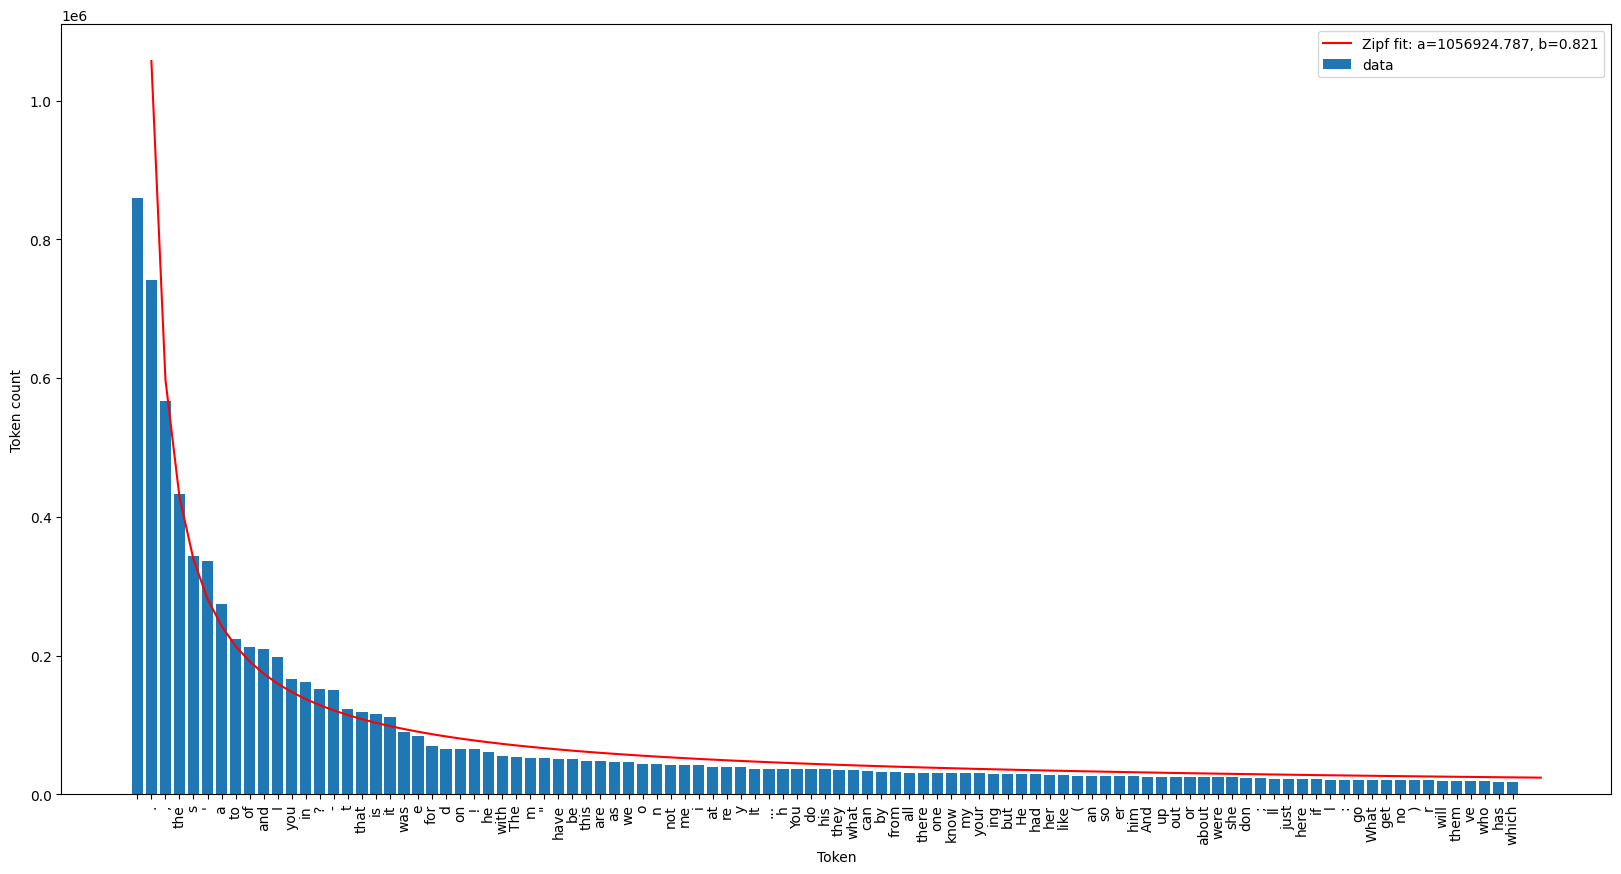

In [7]:
# Fit a Zipfian distribution to the token counts
from scipy.optimize import curve_fit
import numpy as np

CUTOFF = 100
LOG = False

def zipf(x, a, b):
    return a / np.power(x, b)

xdata = np.arange(1, len(sorted_tokens) + 1)
ydata = np.array([token[1] for token in sorted_tokens])

popt, pcov = curve_fit(zipf, xdata, ydata)

# Plot the token counts and the fitted Zipfian distribution
plt.figure(figsize=(20, 10))
#plt.plot(xdata[:100], ydata[:100], 'b-', label='data')
plt.bar([tokenizer.decode([token]) for token, count in sorted_tokens[:CUTOFF]], [count for token, count in sorted_tokens[:CUTOFF]], label='data')
plt.plot(xdata[:CUTOFF], zipf(xdata[:CUTOFF], *popt), 'r-', label='Zipf fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.xlabel('Token')
plt.xticks(rotation=90)
plt.ylabel('Token count')
plt.legend()
plt.yscale('log' if LOG else 'linear')
plt.show()



In [8]:
# For the top 100 and bottom 100 tokens, get the distribution of part-of-speech tags across the whole dataset
pos_counts_top = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[:100]]].sum(axis=0)
pos_counts_bottom = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens[-100:]]].sum(axis=0)

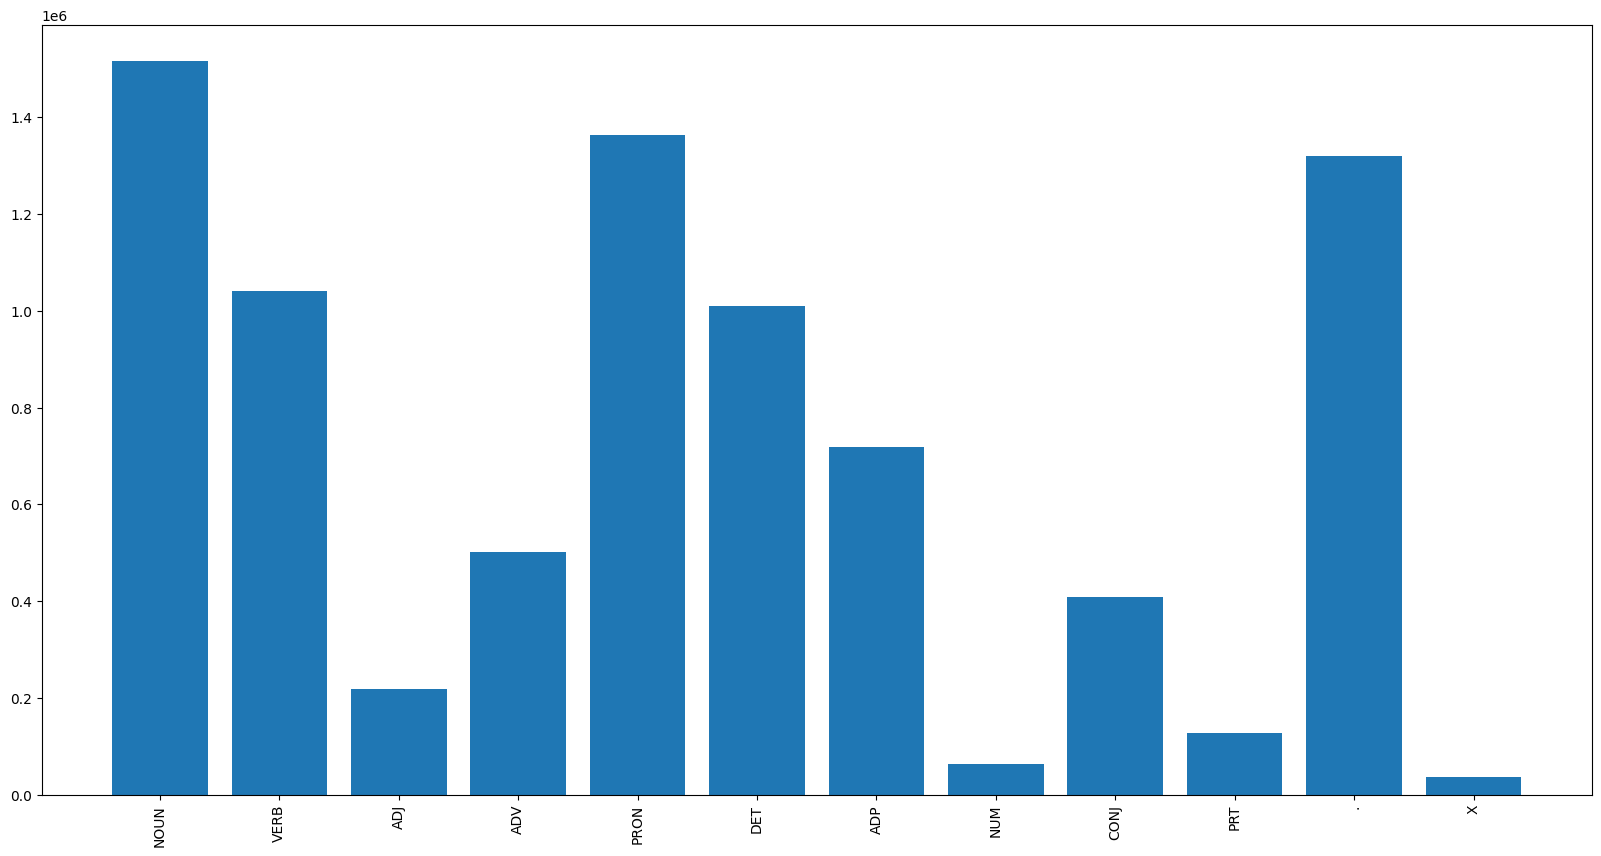

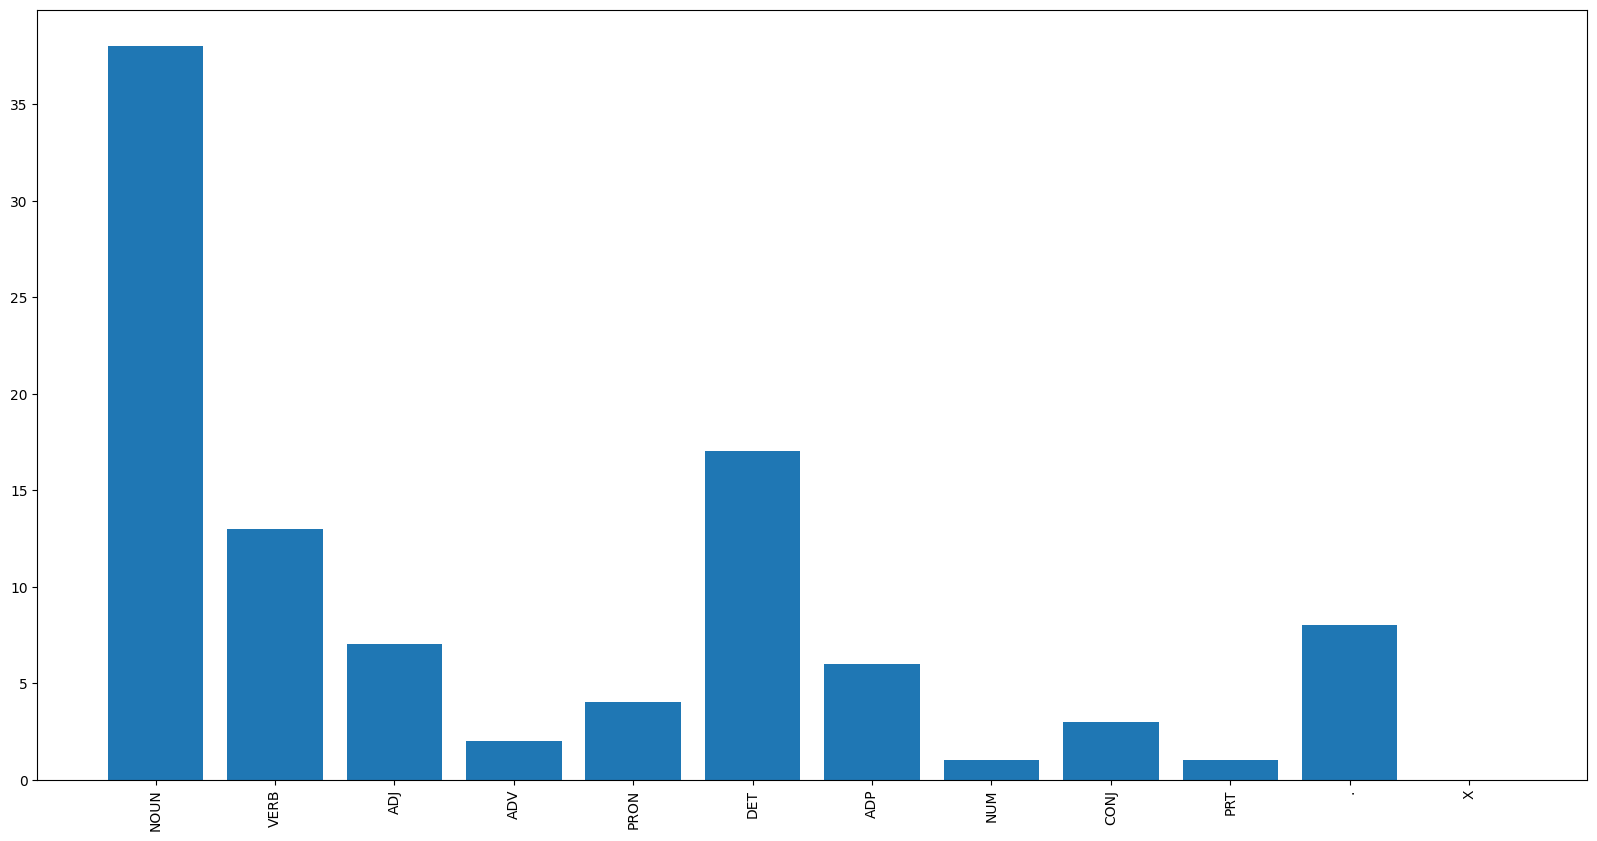

In [9]:
# Plot the distribution of the part-of-speech tags for the top 100 tokens
plt.figure(figsize=(20, 10))
plt.bar([POS_TAG_MAP_REVERSE[tag] for tag, count in enumerate(pos_counts_top)], [count for tag, count in enumerate(pos_counts_top)])
plt.xticks(rotation=90)
plt.show()

# Plot the distribution of the part-of-speech tags for the bottom 100 tokens
plt.figure(figsize=(20, 10))
plt.bar([POS_TAG_MAP_REVERSE[tag] for tag, count in enumerate(pos_counts_top)], [count for tag, count in enumerate(pos_counts_bottom)])
plt.xticks(rotation=90)
plt.show()

In [10]:
# For each token, get the distrubution of part-of-speech tags
pos_counts = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens]]
sums = pos_counts.sum(axis=0)

# Get cumulative distribution of part-of-speech tags, normalise by sums
cumulative_pos_counts = np.cumsum(pos_counts, axis=0) / sums

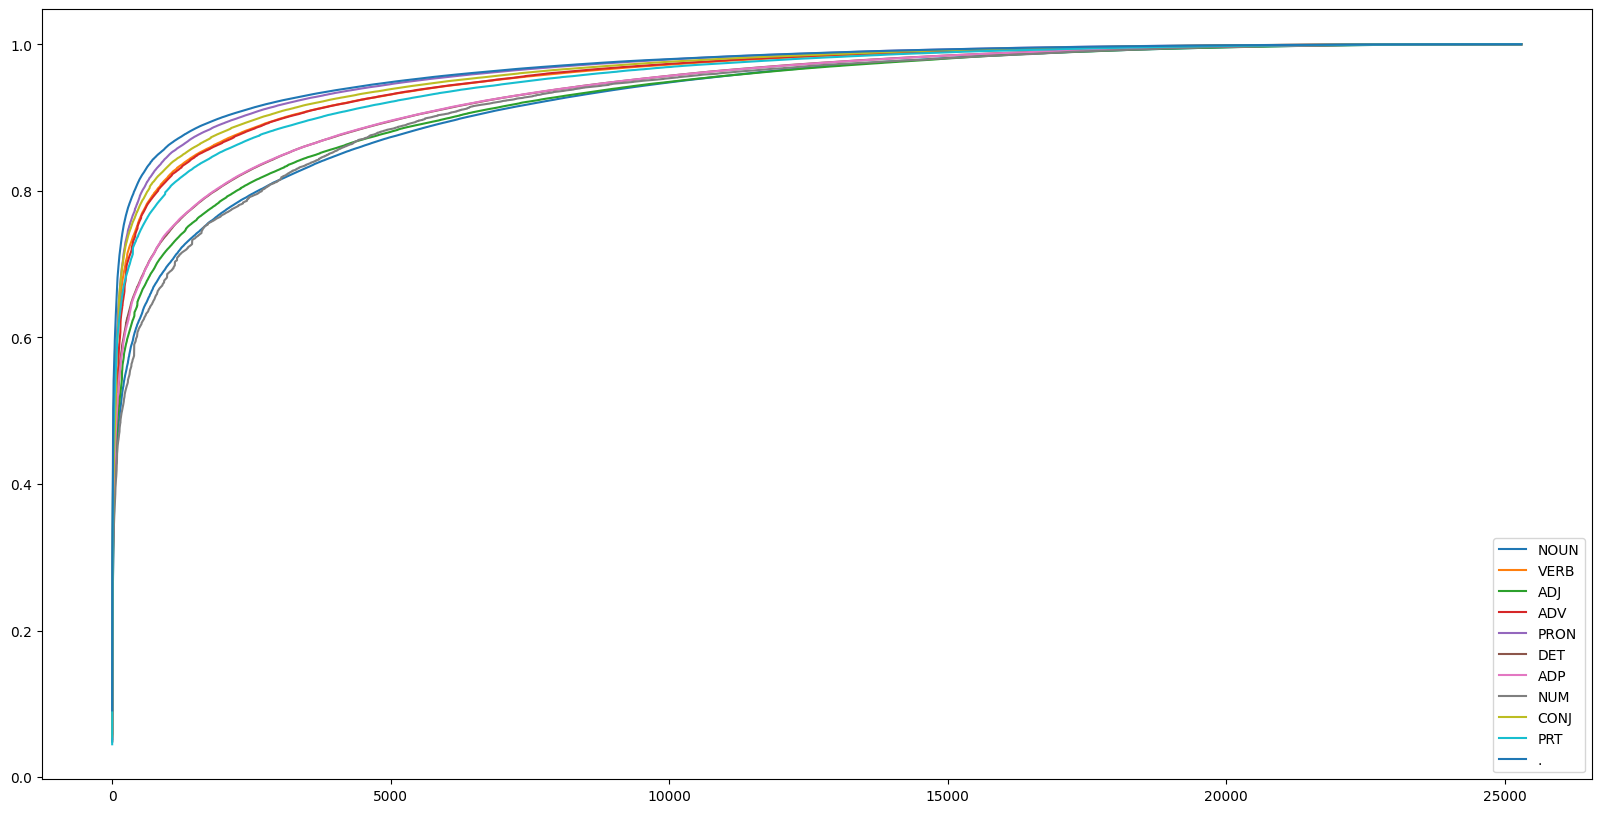

In [11]:
# Plot a cumulative distribution of pos tags counts across all tokens
plt.figure(figsize=(20, 10))
for pos_tag in POS_TAG_MAP.values():
   if pos_tag == 11:
       continue
   plt.plot(cumulative_pos_counts[:, pos_tag], label=POS_TAG_MAP_REVERSE[pos_tag])

plt.legend()
plt.show()



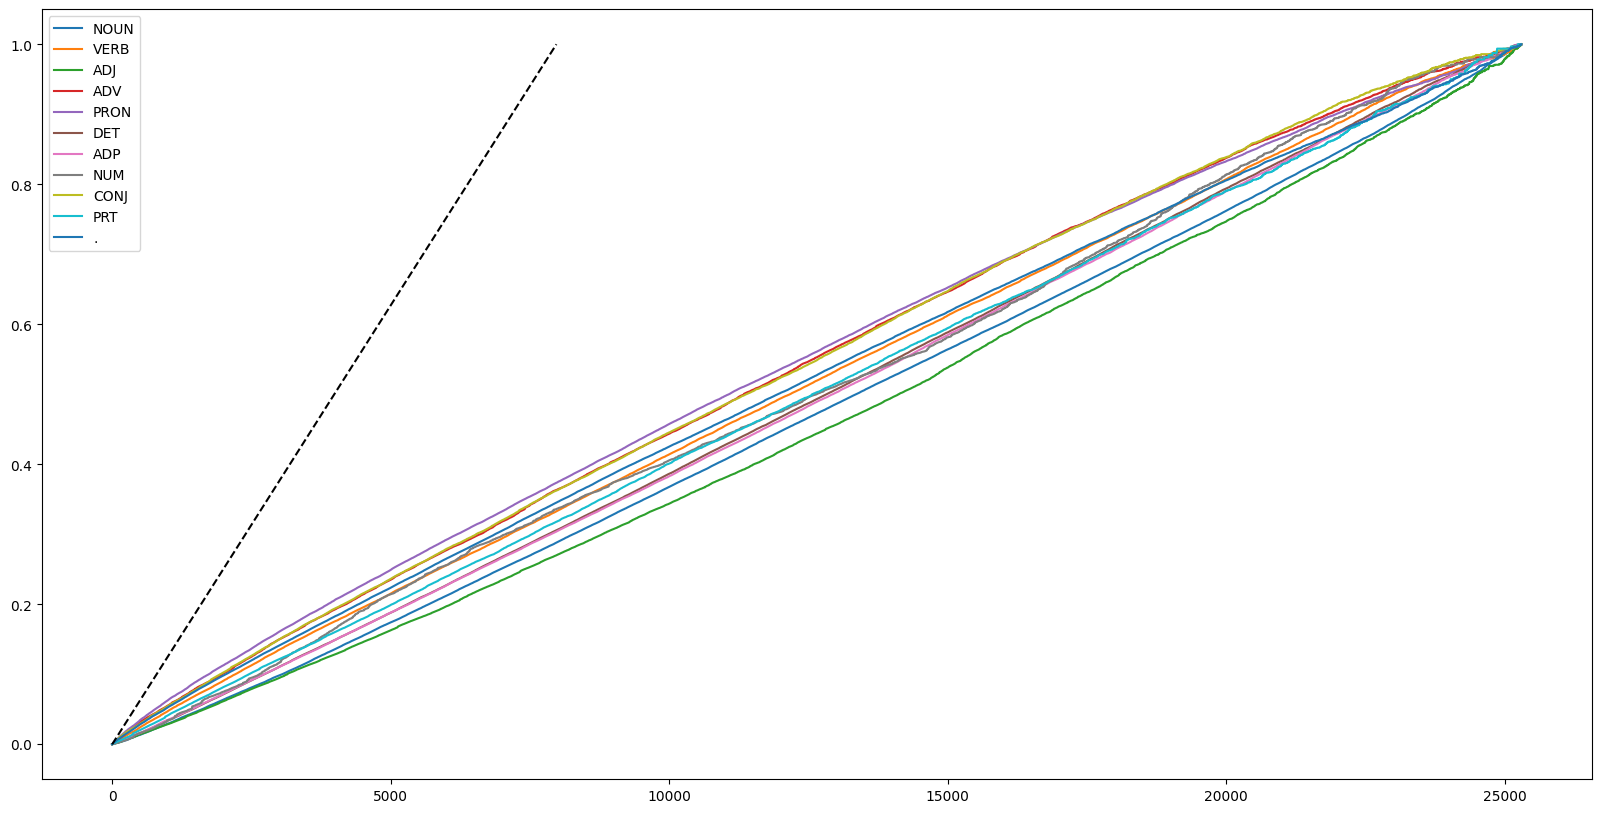

In [12]:
# Normalise for the frequency of each token
from torch import tensor
pos_counts = pos_lookup.lookup_matrix[[a[0] for a in sorted_tokens]]
pos_counts /= tensor([token[1] for token in sorted_tokens]).unsqueeze(1)
sums = pos_counts.sum(axis=0)

# Get cumulative distribution of part-of-speech tags, normalise by sums
cumulative_pos_counts = np.cumsum(pos_counts, axis=0) / sums

# Plot a cumulative distribution of pos tags counts across all tokens
plt.figure(figsize=(20, 10))
for pos_tag in POS_TAG_MAP.values():
   if pos_tag == 11:
       continue
   plt.plot(cumulative_pos_counts[:, pos_tag], label=POS_TAG_MAP_REVERSE[pos_tag])

plt.plot([0, 7975], [0, 1], color='black', linestyle='--')
plt.legend()
plt.show()



# Splitting BLIMP by rare subwords

In [13]:
CHECKPOINT = '../checkpoints/baseline-roberta_pre_layer_norm-model'
predictions_file = CHECKPOINT + '/lm_model/all_predictions.json'

predictions_file = '../checkpoints/opt/all_predictions.json'
predictions_file = '../checkpoints/roberta/all_predictions.json'
predictions_file = '../checkpoints/t5/all_predictions.json'

import pandas as pd
from src.evaluators.blimp_bias_evaluator import BlimpBiasEvaluator, find_replaced_substring

In [14]:
evaluator = BlimpBiasEvaluator(predictions_file, tokenizer, pos_lookup, blimp_data_dir='../lib/evaluation-pipeline/filter-data/blimp_filtered')

Got identical sentences for example 2032 in task binding and subtask principle_A_case_2:
Mark hadn't forgotten about himself skated around some high school.
Got identical sentences for example 2203 in task binding and subtask principle_A_case_2:
Leslie imagined herself skated around the hospital.
Got identical sentences for example 2282 in task binding and subtask principle_A_case_2:
Susan thinks about herself skated around a river.
Got identical sentences for example 2701 in task binding and subtask principle_A_case_2:
Amanda had imagined herself skated around a lot of banks.
Got identical sentences for example 2848 in task binding and subtask principle_A_case_2:
The cashiers think about themselves skated around most museums.
Got identical sentences for example 5829 in task argument_structure and subtask passive_1:
Douglas's senator was left by Susan.
Got identical sentences for example 6246 in task argument_structure and subtask passive_1:
Some grandmother of the cashier was left by 

In [15]:
result = evaluator()
# Convert to dataframe
df = pd.DataFrame(result, index=[0])
df.to_clipboard()

In [16]:
print('Example blimp data:')
print(evaluator.blimp_gold['anaphor_agreement'][0])

print('Example prediction:')
print(evaluator.predictions['predictions'][evaluator.predictions['sub_task'].index('anaphor_agreement')][0])

Example blimp data:
{'sentence_good': "Katherine can't help herself.", 'sentence_bad': "Katherine can't help himself.", 'field': 'morphology', 'linguistics_term': 'anaphor_agreement', 'UID': 'anaphor_gender_agreement', 'simple_LM_method': True, 'one_prefix_method': True, 'two_prefix_method': False, 'lexically_identical': False, 'pair_id': 0}
Example prediction:
{'id': 'anaphor_agreement_0', 'pred': "Katherine can't help himself."}


In [17]:
# Example addition tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,3,4,5,6]))
print(find_replaced_substring([1,2,3,4,5], [1,2,3,3,4,5]))

# Example replacement tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,3,6,6,5]))
print(find_replaced_substring([1,2,3,4,5], [1,2,8,4,5]))

# Example reordering tasks
print(find_replaced_substring([1,2,3,4,5], [1,2,4,3,5]))
print(find_replaced_substring([1,2,3,4,5], [1,2,3,5,4]))

# Example reordering and replacement
print(find_replaced_substring([1,2,3,4,5,6], [4,3,2,1,5,7]))
print(find_replaced_substring([1,2,3,4,5], [4,3,2,1,5]))

([], [6])
([], [3])
([4], [6, 6])
([3], [8])
([3, 4], [4, 3])
([4, 5], [5, 4])
([1, 2, 3, 6], [3, 2, 1, 7])
([1, 2, 3], [3, 2, 1])


In [18]:
evaluator.blimp_gold.keys()

dict_keys(['irregular_forms', 'control_raising', 'binding', 'anaphor_agreement', 'argument_structure', 'island_effects', 'quantifiers', 'subject_verb_agreement', 'npi_licensing', 'ellipsis', 'filler_gap', 'determiner_noun_agreement'])

In [29]:
prediction_data = evaluator.prediction_data
reordering_data = prediction_data[prediction_data['task_type'] == 'reordering']
replacement_data = prediction_data[prediction_data['task_type'] == 'replacement']
addition_data = prediction_data[prediction_data['task_type'] == 'addition']

In [30]:
len(prediction_data[prediction_data['task_type'] == 'replacement']['subtask'].unique())

56

In [74]:
for task in prediction_data['task'].unique():
    print(task)
    subtasks = prediction_data[prediction_data['task'] == task]['subtask'].unique()
    for subtask in subtasks:
        print(subtask)
        print(prediction_data[prediction_data['subtask'] == subtask]['task_type'].value_counts().to_dict())
        # Print first example good sentence and bad sentence
        data = prediction_data[prediction_data['subtask'] == subtask].iloc[0]
        good = data['sentence_good']
        bad = data['sentence_bad']
        frequency_diff = data['difference_average_frequency']
        differing_tokens = data['differing_tokens']
        print(good)
        print(bad)
        print(frequency_diff)
        for token in differing_tokens:
            print(token)
            print(pos_lookup.lookup_matrix[token].sum())
            print(tokenizer.decode([token]))
        

irregular_forms
irregular_past_participle_adjectives
{'replacement': 984}
The hidden offspring aren't confident.
The hid offspring aren't confident.
-4.084384918212891
5697
tensor(284.)
hidden
3
tensor(859925.)

11740
tensor(331.)
hid
irregular_past_participle_verbs
{'replacement': 950, 'addition': 31}
The Borgias wore a lot of scarves.
The Borgias worn a lot of scarves.
0.6480269432067871
8842
tensor(204.)
worn
3
tensor(859925.)

15295
tensor(390.)
wore
control_raising
existential_there_object_raising
{'replacement': 851}
William has declared there to be no guests getting fired.
William has obliged there to be no guests getting fired.
-2.120495319366455
19880
tensor(122.)
oblige
26
tensor(65832.)
d
10126
tensor(340.)
declared
existential_there_subject_raising
{'replacement': 959}
There is soon to be a cat existing.
There is willing to be a cat existing.
1.6179122924804688
4403
tensor(470.)
willing
1116
tensor(2370.)
soon
expletive_it_object_raising
{'replacement': 801}
Tara would asce

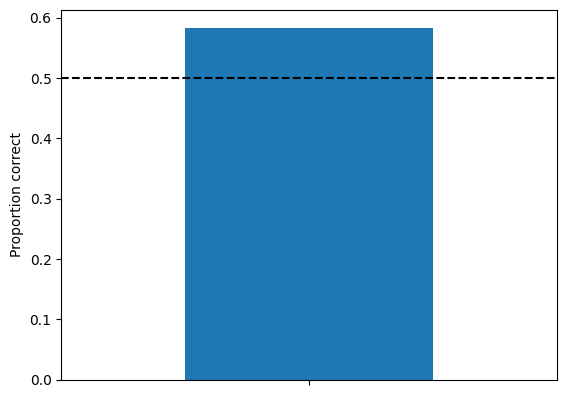

In [32]:
d = prediction_data['correct'].value_counts(normalize=True).drop([False]).plot(kind='bar')
d.set_xticklabels([])
d.set_xlabel('')
d.set_ylabel('Proportion correct')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.show()


<Axes: xlabel='task_type'>

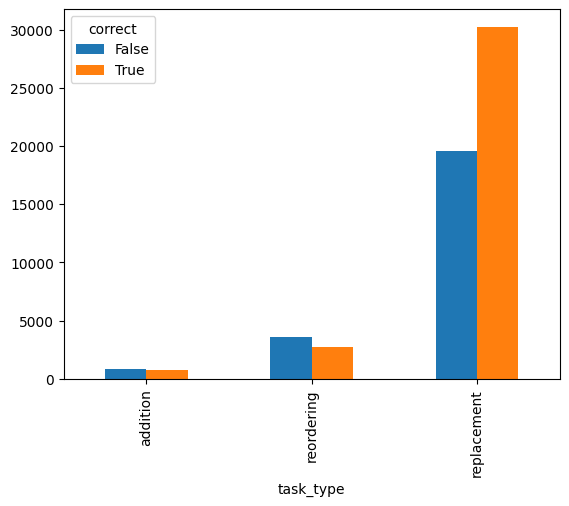

In [33]:
# Plot correct vs not correct for reordering tasks vs non-reordering tasks
prediction_data.groupby(['task_type', 'correct']).size().unstack().plot(kind='bar', stacked=False)

<Axes: xlabel='task_type'>

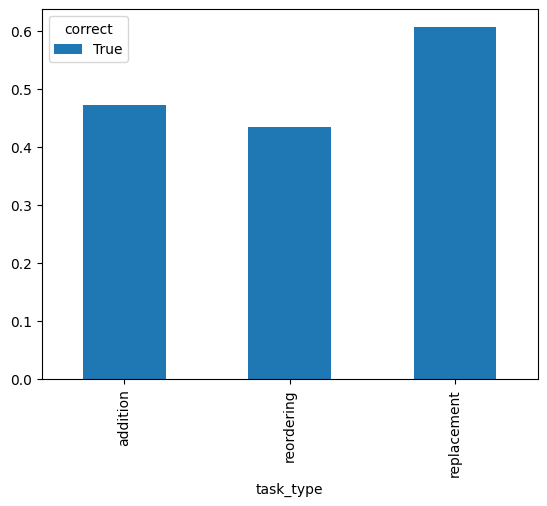

In [34]:
# BLIMP score for each task type
prediction_data.groupby(['task_type', 'correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar')

<Axes: xlabel='differing_tokens'>

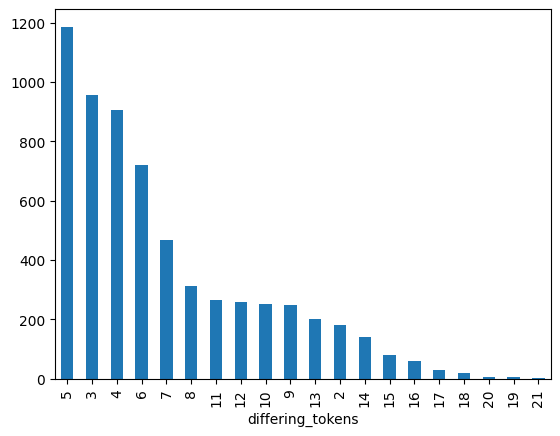

In [35]:
# Plot distribution of length of symmetric difference for reordering tasks
reordering_data['differing_tokens'].apply(lambda x: len(x)).value_counts().plot(kind='bar')

In [37]:
# Show example of one of the longest differences between two sentences
a = prediction_data[prediction_data['differing_tokens'].apply(lambda x: len(x) == 10)].iloc[0]
print(a['sentence_good'])
print(a['sentence_bad'])
print(a['differing_tokens'])
print(a)

a['average_frequency_all_tokens'].item()

Suzanne believes it to be too bad that the girls see Cheryl.
Suzanne wasn't persuading it to be too bad that the girls see Cheryl.
{7, 2088, 9, 76, 399, 17, 53, 26, 7228, 31}
correct                                                                      True
sentence_good                   Suzanne believes it to be too bad that the gir...
sentence_bad                    Suzanne wasn't persuading it to be too bad tha...
task                                                              control_raising
subtask                                               expletive_it_object_raising
differing_tokens                      {7, 2088, 9, 76, 399, 17, 53, 26, 7228, 31}
average_frequency_key_tokens                                            10.092374
task_type                                                             replacement
average_frequency_all_tokens                                             9.545209
min_frequency_key_tokens                                                 4.969813
min_f

9.545209248860678

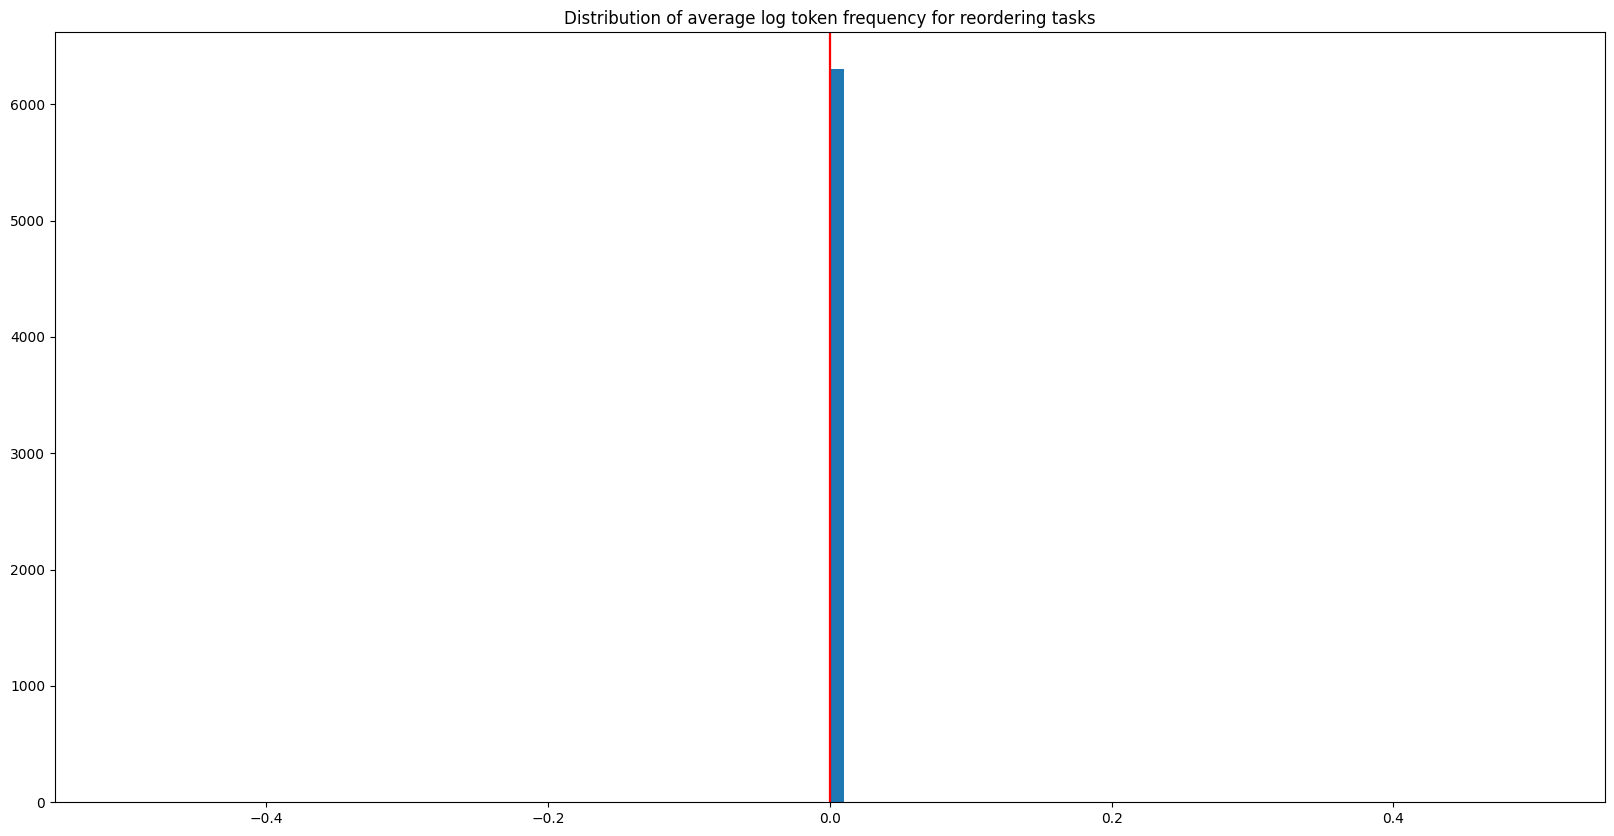

In [38]:
# Plot distribution of average token frequency for reordering tasks
a = reordering_data['difference_average_frequency']


plt.figure(figsize=(20, 10))
plt.hist(a, bins=100)
# Add 50th percentile, 90th percentile and 99th percentile
plt.axvline(x=np.percentile(a, 50), color='red')
plt.axvline(x=np.percentile(a, 90), color='red')
plt.axvline(x=np.percentile(a, 99), color='red')
# Add title
plt.title('Distribution of average log token frequency for reordering tasks')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


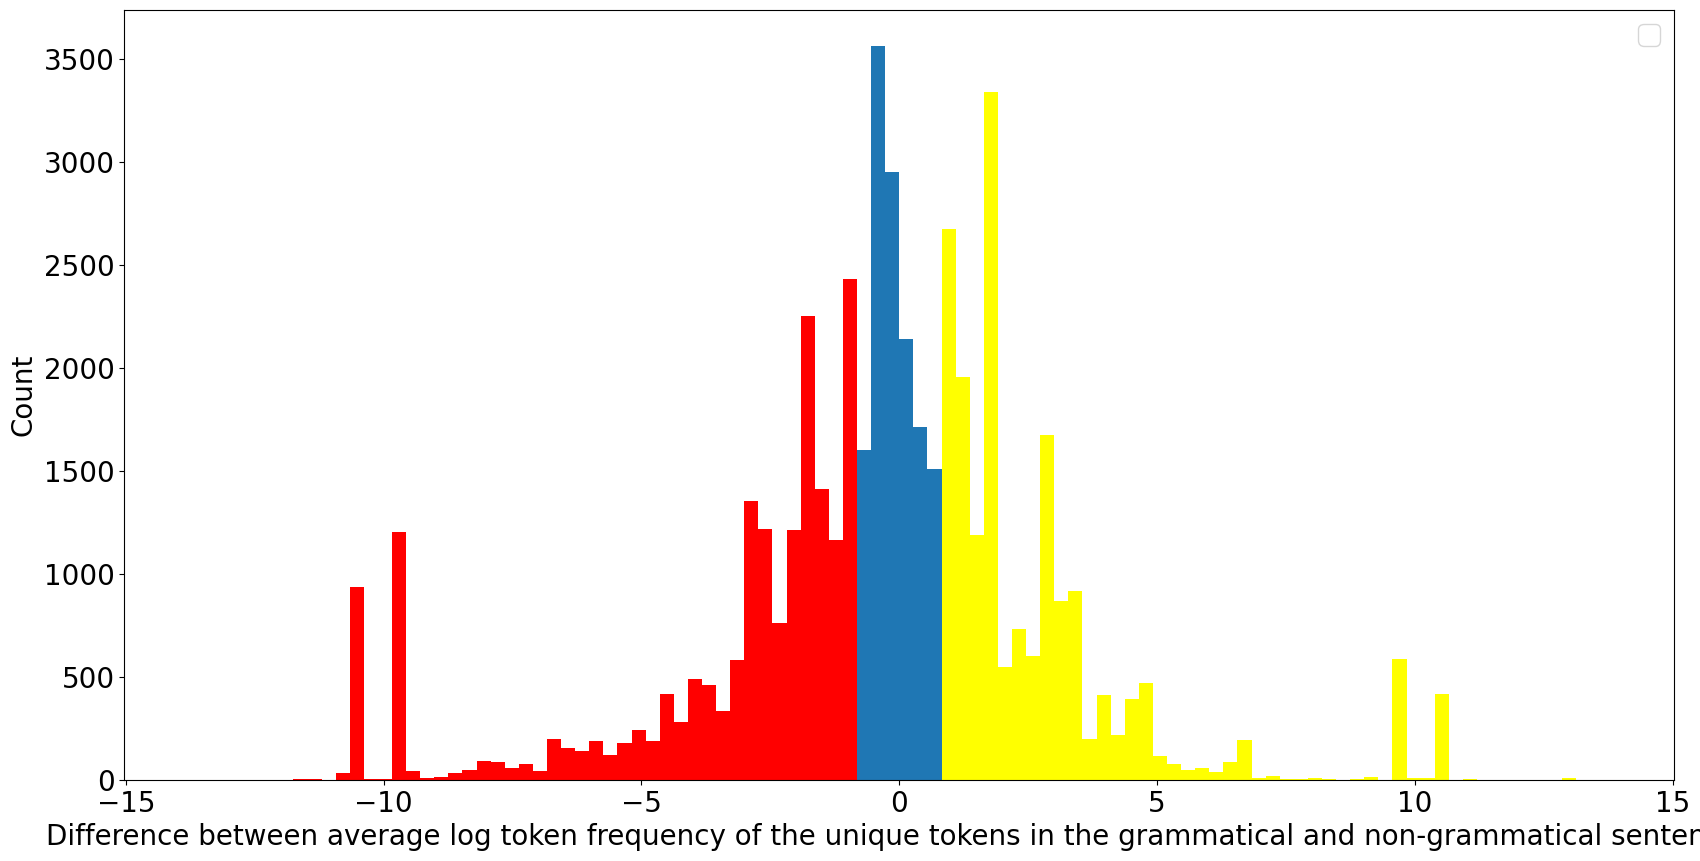

16281
16941
16072


In [69]:
# Plot distribution of average token frequency for key tokens in non-reordering tasks
a = replacement_data['difference_average_frequency']

# Set text size to 20
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(20, 10))
plt.hist(a, bins=100)
# Add 50th percentile, 90th percentile and 99th percentile
# plt.axvline(x=np.percentile(a, 33), color='black', label='33rd percentile')
# plt.axvline(x=np.percentile(a, 50), color='black',label='50th percentile')
# plt.axvline(x=np.percentile(a, 66), color='black',label='66th percentile')

# Colour all bins to the left of the 66th percentile dark blue
for i in range(47):
    plt.gca().patches[i].set_facecolor('red')

# Colour all bins to the right of the 66th percentile blue
for i in range(53,100):
    plt.gca().patches[i].set_facecolor('yellow')

# Add title
#plt.title('Distribution of the difference between average log token frequency for reordering tasks')
plt.ylabel('Count')
plt.xlabel('Difference between average log token frequency of the unique tokens in the grammatical and non-grammatical sentences')
plt.legend()
plt.show()

print(len(a[a < np.percentile(a, 33)]))
print(len(a[a > np.percentile(a, 66)]))
print(len(a[(a > np.percentile(a, 33)) & (a < np.percentile(a, 66))]))

# Now do the same but split for each subtask
# for subtask in replacement_data['subtask'].unique():
#     a = replacement_data[replacement_data['subtask'] == subtask]['difference_average_frequency']
#     plt.figure(figsize=(20, 10))
#     plt.hist(a, bins=100)
#     # Add 50th percentile, 90th percentile and 99th percentile
#     plt.axvline(x=np.percentile(a, 50), color='red')
#     plt.axvline(x=np.percentile(a, 90), color='red')
#     plt.axvline(x=np.percentile(a, 99), color='red')
#     # Add title
#     plt.title(subtask)
#     plt.show()

In [ ]:
# Show example of one of the sentences with the lowest average frequency of key tokens
# Sort by average frequency and take the first example
a = replacement_data.sort_values(by=['difference_average_frequency'], ascending=True).iloc[100]
print(a['sentence_good'])
print(a['sentence_bad'])
print('Average frequency of all tokens:', a['average_frequency_all_tokens'])
print(a['differing_tokens'],'=',[tokenizer.decode([token]) for token in a['differing_tokens']])
frequencies = [token_counts[token] for token in tokenizer.encode(a['sentence_good']) if not token in special_ids]
#print('Tokens:' , [tokenizer.decode([token]) for token in tokenizer.encode(a['sentence_good']) if not token in special_ids])
print(frequencies)

Craig hadn't learned that the teenager that is investigating Winston Churchill notices a lot of college campuses.
Craig hadn't learned what the teenager that is investigating Winston Churchill notices a lot of college campuses.
Average frequency of all tokens: 7.91823296797903
{99, 14} = [' what', ' that']
[tensor(26.), tensor(400.), tensor(70395.), tensor(657.), tensor(114715.), tensor(427400.), tensor(68.), tensor(114715.), tensor(110487.), tensor(74.), tensor(52.), tensor(63.), tensor(43.), tensor(197345.), tensor(4697.), tensor(210726.), tensor(779.), tensor(20.), tensor(666265.)]


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_12728/1955300690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)


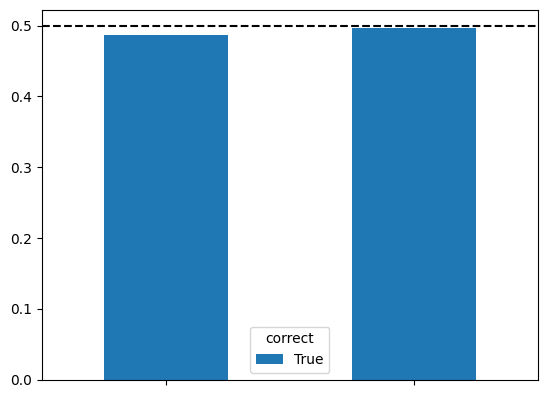

In [ ]:
def plot_correct_incorrect_for_frequency(data, percentile, frequency_column='average_frequency_all_tokens'):
    percentile = np.percentile(data[frequency_column], percentile)
    data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)
    # Get number of correct and incorrect predictions for each group as a percentage of the total number of predictions
    d = data.groupby(['high_frequency', 'correct']).size().unstack().apply(lambda x: x / x.sum(), axis=1).drop([False], axis=1).plot(kind='bar', stacked=False)
    d.set_xticklabels([])
    d.set_xlabel('')
    # Add dashed line at 0.5
    plt.axhline(y=0.5, color='black', linestyle='--')

plot_correct_incorrect_for_frequency(reordering_data, 50, frequency_column='min_frequency_all_tokens')


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_12728/1955300690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['high_frequency'] = data[frequency_column].apply(lambda x: x > percentile)


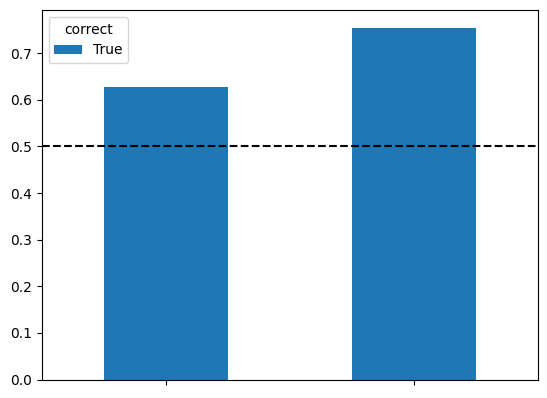

In [ ]:
plot_correct_incorrect_for_frequency(replacement_data, 80, 'difference_min_frequency')

In [ ]:
split_data = evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')
increasing = sum([split_data[task]['high_frequency'] - split_data[task]['low_frequency'] for task in split_data if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0])
total = sum([1 for task in split_data if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0])
print(increasing / total)

split_scores_all = evaluator.get_split_scores_all('replacement', 33, 66, 'difference_average_frequency')
print(split_scores_all['high_frequency'] - split_scores_all['low_frequency'])

split_scores_all_by_task = evaluator.get_split_scores_all_by_task('replacement', 33, 66, 'difference_average_frequency')
print(split_scores_all_by_task['high_frequency'] - split_scores_all_by_task['low_frequency'])

0.015834424802478785
0.10557039572202598
0.014217385112039516


Percentage count increasing: 56.52173913043478


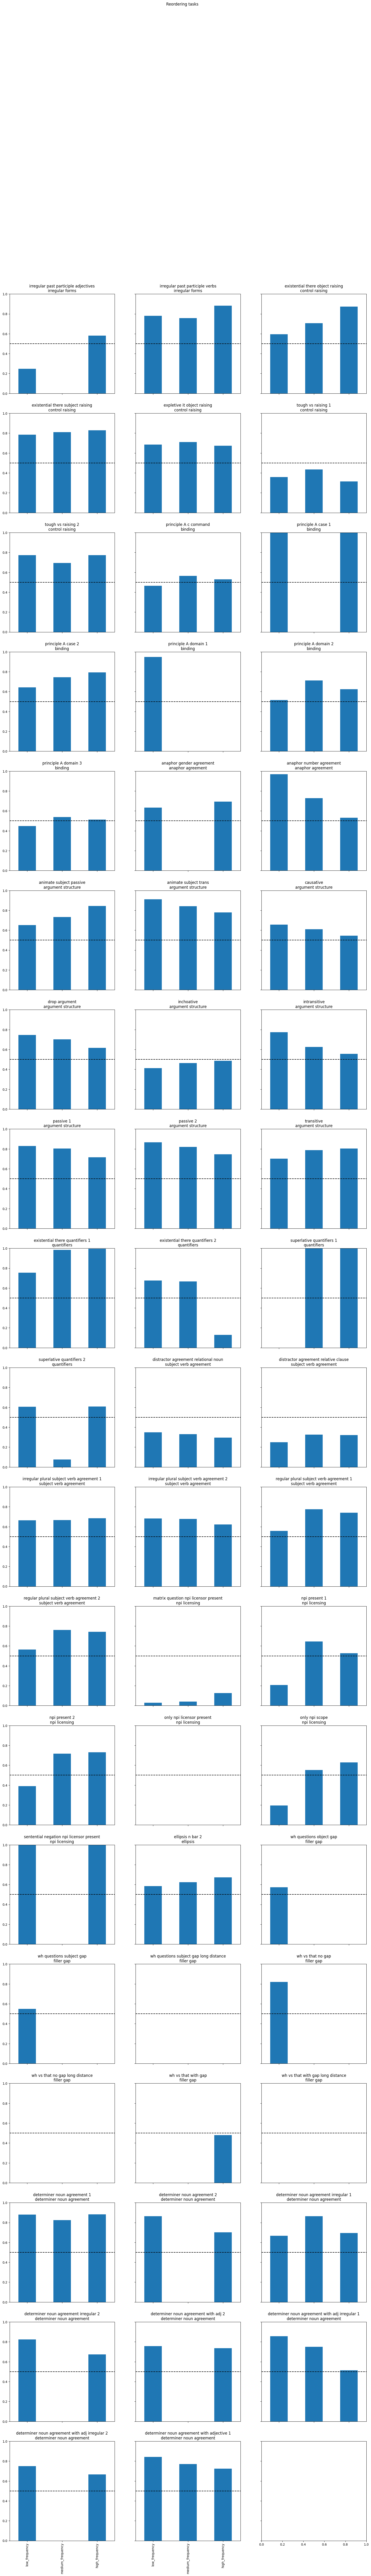

In [ ]:
def plot_split_data(split_data):
    num_tasks = split_data.shape[1]
    fig, axs = plt.subplots(num_tasks // 3 + 1, 3, figsize=(20, 20 * (num_tasks // 3 + 1) / 3))
    count_increasing = 0
    total = 0
    for i, task in enumerate(split_data):
        ax = axs[i // 3, i % 3,]
        split_data[task].plot(kind='bar', stacked=False, ax=ax)
        # Add dashed line at 0.5
        ax.axhline(y=0.5, color='black', linestyle='--')
        # Add one to count_increasing if the proportion of correct predictions increases from the bottom to the top
        if split_data[task]['low_frequency'] != 0 and split_data[task]['high_frequency'] != 0:
            total += 1
            if split_data[task]['low_frequency'] < split_data[task]['high_frequency']:
                count_increasing += 1
        ax.set_xlabel('')
        ax.set_title(task)
    print('Percentage count increasing:', count_increasing / total * 100)
    fig.suptitle('Reordering tasks')
    # Hide x labels unless it is the bottom row
    for ax in axs.flat:
        ax.label_outer()
    # Ensure scale is always 0 to 1
    for ax in axs.flat:
        ax.set_ylim([0, 1])
    
    #fig.tight_layout()
    # Hide x label
    #fig.tight_layout()
    plt.show()

plot_split_data(split_data)

In [ ]:
good = a['sentence_good']
bad = a['sentence_bad']

# Find the two words that were swapped between the two sentences
good_tokens = tokenizer.encode(good)
bad_tokens = tokenizer.encode(bad)
good_tokens = [tokenizer.decode([token]) for token in good_tokens]
bad_tokens = [tokenizer.decode([token]) for token in bad_tokens]
print(good_tokens)
print(bad_tokens)

for i in range(len(good_tokens)):
    if good_tokens[i] != bad_tokens[i]:
        print(f'Index {i} is different: {good_tokens[i]} vs {bad_tokens[i]}')


['<s>', 'Craig', ' hadn', "'t", ' learned', ' that', ' the', ' teenager', ' that', ' is', ' investigating', ' Winston', ' Churchill', ' notices', ' a', ' lot', ' of', ' college', ' campuses', '.']
['<s>', 'Craig', ' hadn', "'t", ' learned', ' what', ' the', ' teenager', ' that', ' is', ' investigating', ' Winston', ' Churchill', ' notices', ' a', ' lot', ' of', ' college', ' campuses', '.']
Index 5 is different:  that vs  what


In [ ]:
# Pick first example given a subtask
def get_example(data, subtask):
    print(data[data['subtask'] == subtask].iloc[0])
    # Print frequencies of each differing token
    print('Frequencies of each differing token:')
    print([token_counts[token] for token in data[data['subtask'] == subtask].iloc[0]['differing_tokens']])
    print('Tokens:')
    print([tokenizer.decode([token]) for token in data[data['subtask'] == subtask].iloc[0]['differing_tokens']])


get_example(replacement_data, 'irregular_past_participle_verbs')

correct                                                       True
sentence_good                   The Borgias wore a lot of scarves.
sentence_bad                    The Borgias worn a lot of scarves.
task                                               irregular_forms
subtask                            irregular_past_participle_verbs
differing_tokens                                     {5328, 10610}
average_frequency_key_tokens                               5.47578
task_type                                              replacement
average_frequency_all_tokens                              8.157002
min_frequency_key_tokens                                  5.313206
min_frequency_all_tokens                                  3.465736
difference_average_frequency                              0.325149
difference_min_frequency                                  0.325149
high_frequency                                               False
Name: 984, dtype: object
Frequencies of each differing token:


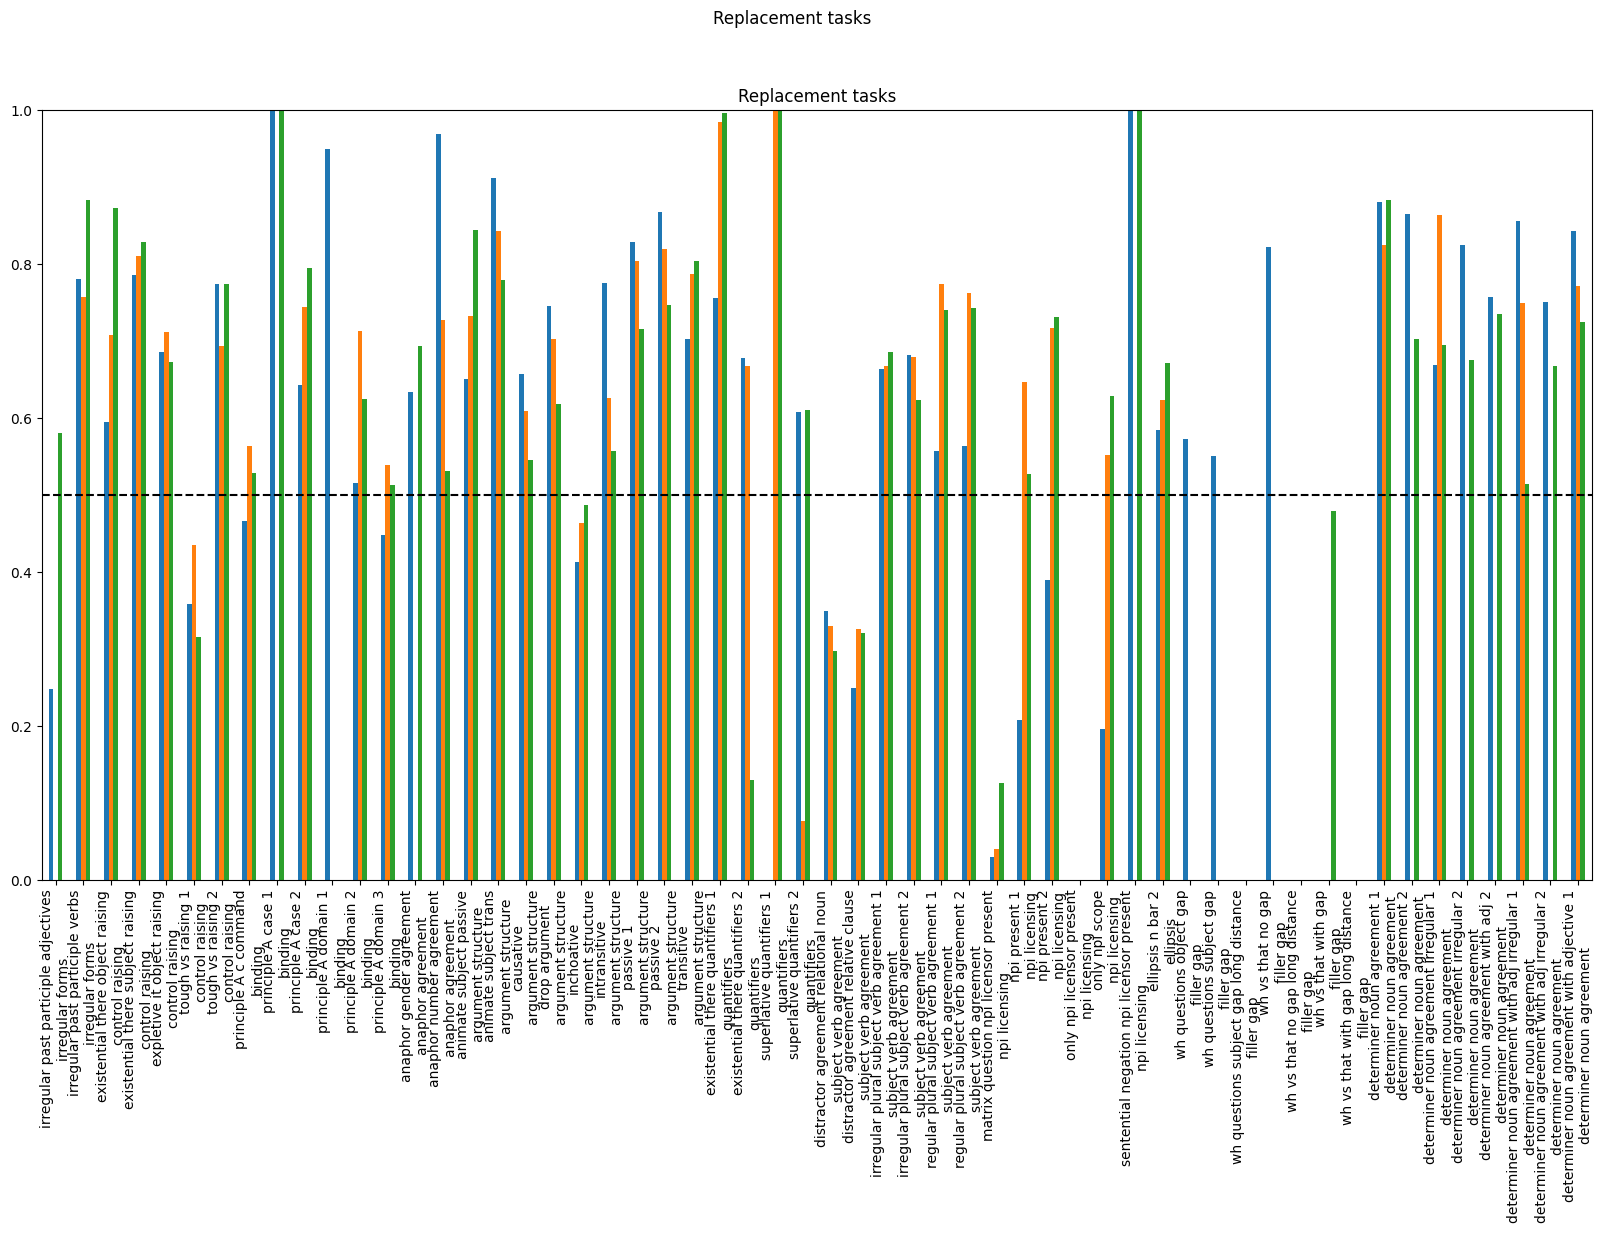

In [ ]:
r = evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')
r = pd.DataFrame(r).transpose()
# Plot the results
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
r.plot(kind='bar', stacked=False, ax=axs)
# Add dashed line at 0.5
axs.axhline(y=0.5, color='black', linestyle='--')
# Hide x label
axs.set_xlabel('')
axs.set_title('Replacement tasks')
axs.get_legend().remove()
fig.suptitle('Replacement tasks')
# Hide x labels unless it is the bottom row
axs.label_outer()
# Ensure scale is always 0 to 1
axs.set_ylim([0, 1])
plt.show()


In [ ]:
r

,low_frequency,medium_frequency,high_frequency
irregular past participle adjectives\nirregular forms,0.248175,0.000000,0.580442
irregular past participle verbs\nirregular forms,0.779605,0.756654,0.882540
existential there object raising\ncontrol raising,0.594306,0.707143,0.871972
existential there subject raising\ncontrol raising,0.785489,0.810127,0.828221
expletive it object raising\ncontrol raising,0.685606,0.711027,0.672794
tough vs raising 1\ncontrol raising,0.357367,0.434921,0.314815
tough vs raising 2\ncontrol raising,0.773163,0.693291,0.773292
principle A c command\nbinding,0.465190,0.563725,0.528620
principle A case 1\nbinding,1.000000,0.000000,1.000000
principle A case 2\nbinding,0.641935,0.744337,0.794304


In [ ]:
evaluator.get_split_scores_per_task('replacement', 33, 66, 'difference_average_frequency')

,irregular past participle adjectives\nirregular forms,irregular past participle verbs\nirregular forms,existential there object raising\ncontrol raising,existential there subject raising\ncontrol raising,expletive it object raising\ncontrol raising,tough vs raising 1\ncontrol raising,tough vs raising 2\ncontrol raising,principle A c command\nbinding,principle A case 1\nbinding,principle A case 2\nbinding,...,wh vs that with gap\nfiller gap,wh vs that with gap long distance\nfiller gap,determiner noun agreement 1\ndeterminer noun agreement,determiner noun agreement 2\ndeterminer noun agreement,determiner noun agreement irregular 1\ndeterminer noun agreement,determiner noun agreement irregular 2\ndeterminer noun agreement,determiner noun agreement with adj 2\ndeterminer noun agreement,determiner noun agreement with adj irregular 1\ndeterminer noun agreement,determiner noun agreement with adj irregular 2\ndeterminer noun agreement,determiner noun agreement with adjective 1\ndeterminer noun agreement
low_frequency,0.248175,0.779605,0.594306,0.785489,0.685606,0.357367,0.773163,0.465190,1.0,0.641935,...,0.000000,0,0.880126,0.864000,0.667883,0.824561,0.756098,0.855705,0.750000,0.842271
medium_frequency,0.000000,0.756654,0.707143,0.810127,0.711027,0.434921,0.693291,0.563725,0.0,0.744337,...,0.000000,0,0.824841,0.000000,0.862661,0.000000,0.000000,0.748918,0.000000,0.770968
high_frequency,0.580442,0.882540,0.871972,0.828221,0.672794,0.314815,0.773292,0.528620,1.0,0.794304,...,0.478261,0,0.882911,0.702041,0.693950,0.674510,0.735160,0.513245,0.666667,0.724458


# Perplexity

In [ ]:
PERPLEXITY_FILE = '../checkpoints/baseline-roberta_pre_layer_norm-model/lm_model/predictions.json'

In [ ]:
perplexities = load_dataset('json', data_files=PERPLEXITY_FILE, split='train', field='predictions').to_pandas()

In [ ]:
perplexities

,per_token_loss,id,input_ids,perplexity
0,"[0.0, 4.240802764892578, 7.9829559326171875, 9...",perplexity_0,"[3, 264, 773, 1852, 382, 364, 568, 266, 7056, ...",496.920380
1,"[2.999039649963379, 11.116632461547852, 11.168...",perplexity_1,"[18, 6524, 4867, 320, 321, 597, 284, 1448, 291...",575.749878
2,"[7.5909037590026855, 4.170400142669678, 9.5199...",perplexity_2,"[301, 284, 2226, 1197, 18, 307, 317, 380, 266,...",466.098633
3,"[5.043636322021484, 5.644055366516113, 4.14707...",perplexity_3,"[321, 376, 263, 6077, 18, 518, 366, 2748, 18, ...",400.834595
4,"[7.767001628875732, 7.506594657897949, 4.33121...",perplexity_4,"[760, 704, 291, 1907, 264, 528, 315, 4816, 411...",791.233093
...,...,...,...,...
96,"[5.323674201965332, 6.272162437438965, 6.29776...",perplexity_96,"[361, 354, 354, 79, 312, 6681, 360, 401, 2044,...",3413.177246
97,"[5.97589111328125, 7.933274269104004, 7.783666...",perplexity_97,"[453, 268, 312, 990, 295, 1715, 16, 3514, 16, ...",2588.086670
98,"[7.08505392074585, 4.672813892364502, 6.802525...",perplexity_98,"[31, 307, 650, 5614, 5200, 3967, 266, 3670, 42...",2399.533203
99,"[11.935686111450195, 4.019516944885254, 9.0196...",perplexity_99,"[5893, 294, 3894, 18, 360, 897, 1654, 998, 420...",2183.149414


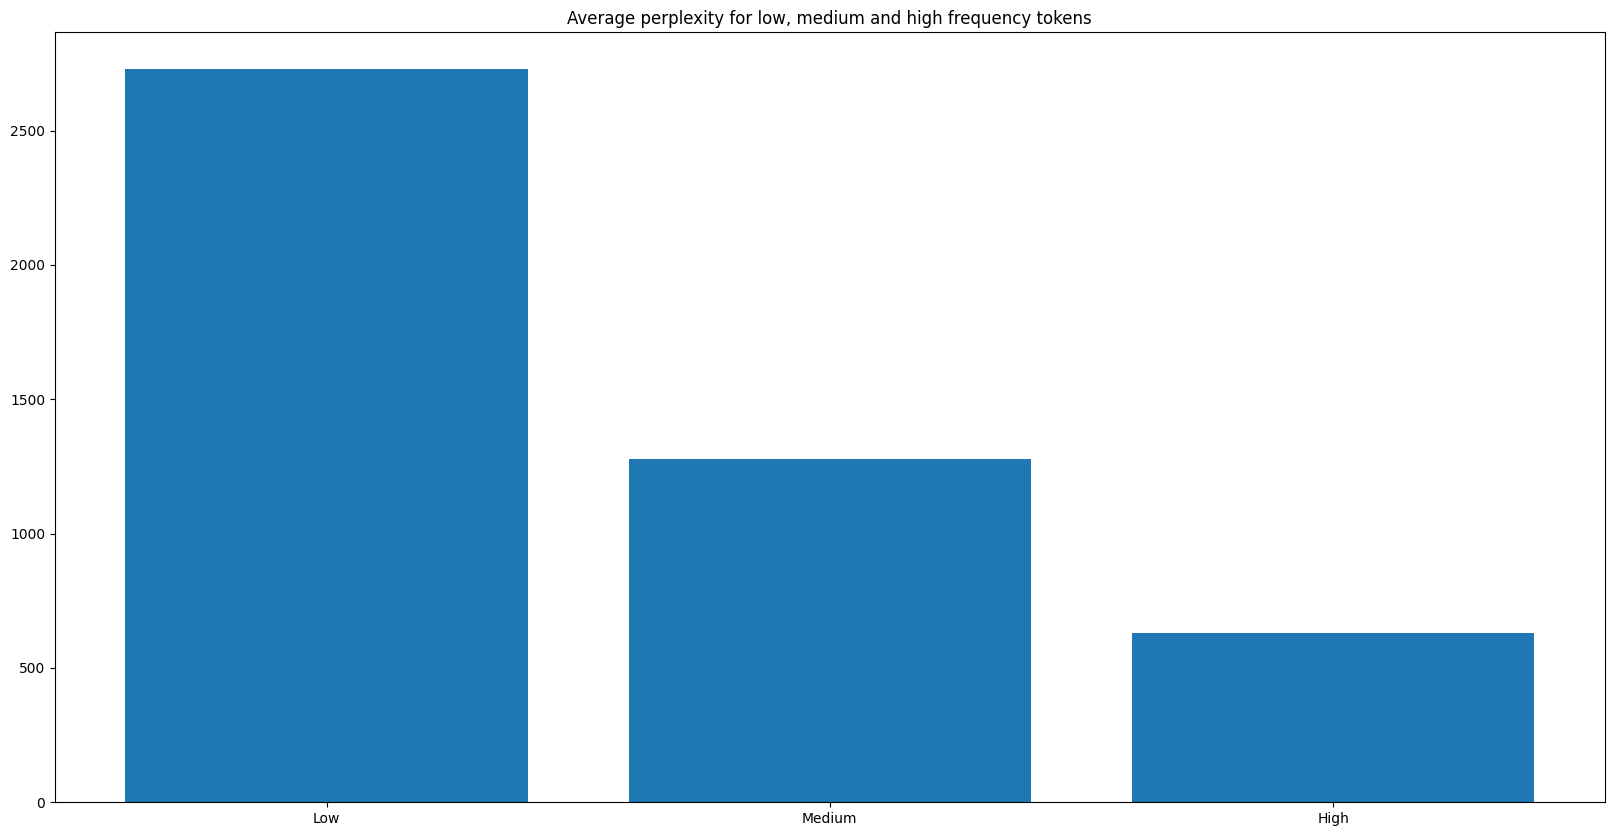

In [ ]:
perplexities['average_frequency'] = perplexities['input_ids'].apply(lambda tokens: np.mean(np.log([token_counts[token] for token in tokens if not token in special_ids])))
lower_percentile = np.percentile(perplexities['average_frequency'], 33)
upper_percentile = np.percentile(perplexities['average_frequency'], 66)

# Plot average perplexity for low, medium and high frequency tokens
perplexity_low = perplexities[perplexities['average_frequency'] < lower_percentile]['perplexity'].mean()
perplexity_medium = perplexities[(perplexities['average_frequency'] >= lower_percentile) & (perplexities['average_frequency'] < upper_percentile)]['perplexity'].mean()
perplexity_high = perplexities[perplexities['average_frequency'] >= upper_percentile]['perplexity'].mean()

plt.figure(figsize=(20, 10))
plt.bar(['Low', 'Medium', 'High'], [perplexity_low, perplexity_medium, perplexity_high])
plt.title('Average perplexity for low, medium and high frequency tokens')
plt.show()


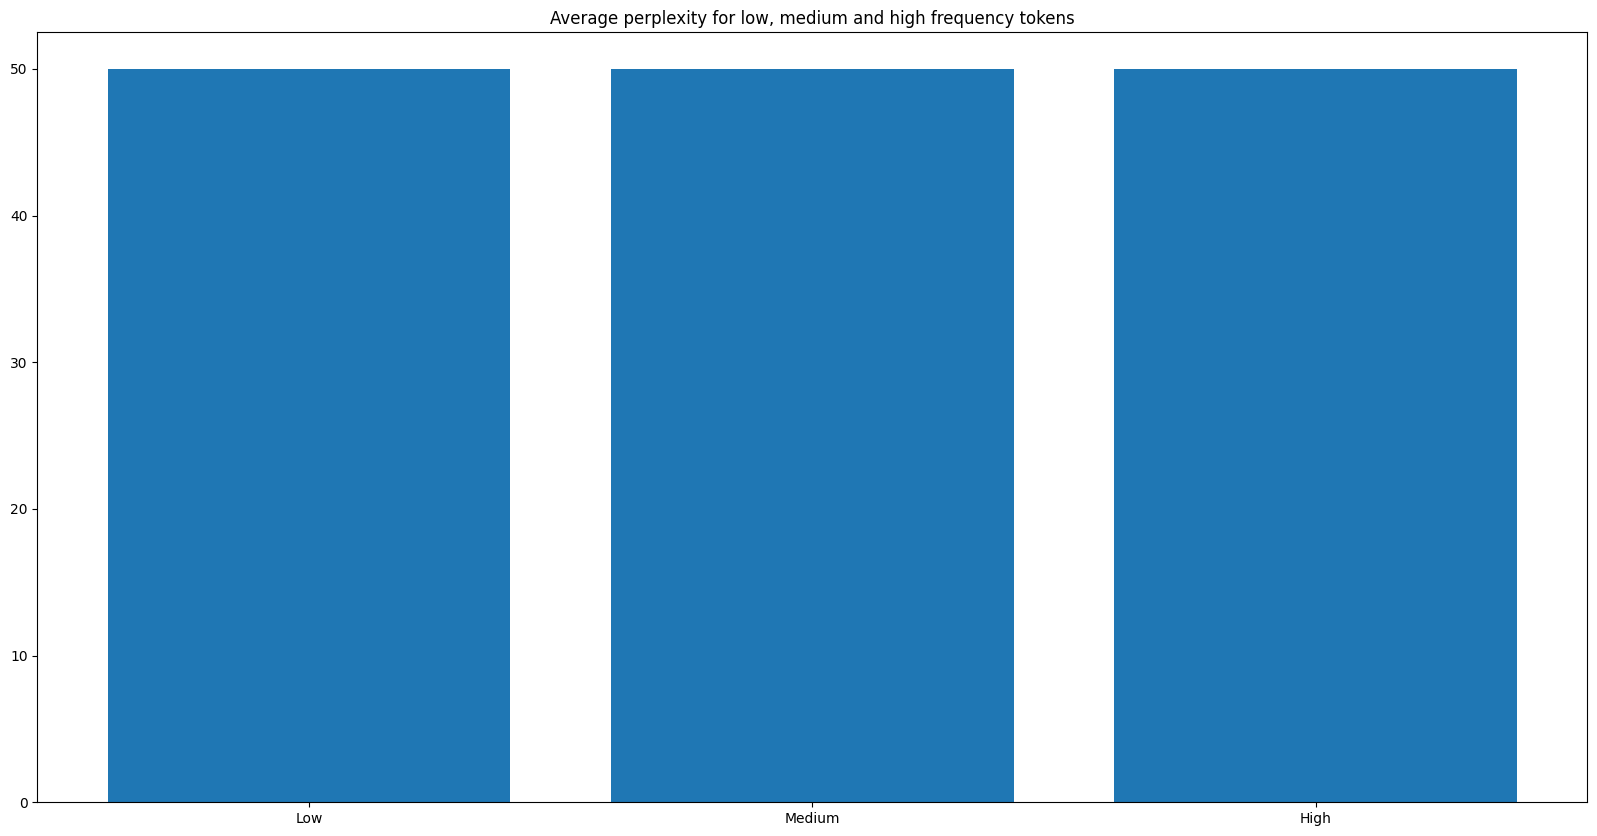

In [ ]:

plt.figure(figsize=(20, 10))
plt.bar(['Low', 'Medium', 'High'], [50, 50, 50])
plt.title('Average perplexity for low, medium and high frequency tokens')
plt.show()
